In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.sparse.linalg import eigsh

from skimage.measure import block_reduce

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [3]:
import numpy as np
import os

def load_registered_sample(base_directory,registered_directory,start,end):
    corrected_svt = np.load(os.path.join(base_directory, "Corrected_SVT.npy"))
    u = np.load(os.path.join(registered_directory, "Registered_U.npy"))
    delta_f_sample = np.dot(u, corrected_svt[:, start:end])
    return delta_f_sample

def normalize_periodograms(S):
    #try to normalize each signal dividing by its maximum
    max_values = np.max(S, axis=1)
    # divide each row by its maximum value
    S = S / max_values.reshape(-1, 1)
    return S

def compute_distance(i,j,H,W,loc):
    r_i, c_i = np.unravel_index(loc[0][i], (H,W))
    r_j, c_j = np.unravel_index(loc[0][j], (H,W))
    return np.sqrt((r_i-r_j)^2+(c_i-c_j)^2)

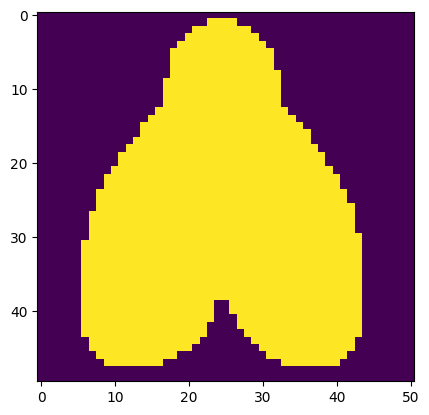

In [4]:
mask_dict = np.load(r"/home/k21208334/calcium_analyses/data/Tight_Mask_Dict.npy", allow_pickle=True)[()]

array_indicies = np.array(mask_dict['indicies'])

image = np.ravel(np.zeros((mask_dict['image_height'],mask_dict['image_width'])))
image[array_indicies]=1
plt.imshow(np.reshape(image,(300,304)))

downsampled_tight_mask = block_reduce(np.reshape(image,(300,304)), block_size=(6,6), func=np.min) 
plt.imshow(downsampled_tight_mask)

final_mask = downsampled_tight_mask>0

In [5]:
h=300
w=304
connectivity_thr = 0.2
window_size = 140

start = 0
end = 25000
connectivity_thr = 0.2

In [6]:
names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

for name in names+names_knock: # first one already done

    print("\n starting: ",name)
    walking = np.load("/home/k21208334/calcium_analyses/data/walking/"+name+".npy")
    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"
    sample = load_registered_sample(base_directory,registered_directory,start,end)
    coarse_sample = block_reduce(sample, block_size=(6,6,1), func=np.mean) 
    #  connectivity: flatten data
    H = np.shape(coarse_sample)[0]
    W = np.shape(coarse_sample)[1]
    all_signals = np.reshape(coarse_sample,(H*W,end))
    # remove zero signals based on mask!
    good_indices = np.ravel(final_mask)
    signals = all_signals[good_indices,:]
    
    # ok now I have the signals
    leading_eigenvectors = np.empty((0,signals.shape[0]))

    for i in range(signals.shape[1]):
        matrix = connectivity_measures.get_instantaneous_matrix(window_size,signals,i)
        eigenvalue, eigenvector = eigsh(matrix, k=1)
        if np.sum(eigenvector)>0:
            eigenvector=-eigenvector;
        # normalize eigenvector
        eigenvector = eigenvector/(np.linalg.norm(eigenvector))
        leading_eigenvectors=np.vstack((leading_eigenvectors,eigenvector.T))
        
    tosave = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/' + name
    np.save(tosave,leading_eigenvectors)


 starting:  NXAK22.1A

 starting:  NXAK14.1A

 starting:  NXAK7.1B

 starting:  NXAK4.1B

 starting:  NRXN78.1D

 starting:  NRXN78.1A

 starting:  NXAK24.1C

 starting:  NXAK20.1B

 starting:  NXAK16.1B

 starting:  NXAK10.1A

 starting:  NXAK4.1A

 starting:  NRXN71.2A


In [ ]:
# NOTE: WHEN IT'S DONE, CHECK IF 1ST SUBJECT IS OK!!!!

In [ ]:
# ripartire da qua quando hai finito: fare unico clustering e mettere cosine distance!

In [14]:
#eigenvectors_wild = np.empty((0,signals.shape[0]))
#eigenvectors_knock = np.empty((0,signals.shape[0]))
eigenvectors_all = np.empty((0,signals.shape[0]))

# load clustered data 

for name in names+names_knock:

    data = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/' + name + ".npy"
    centr = np.load(data)
    eigenvectors_all = np.vstack((eigenvectors_all,centr))

In [26]:
def plot_centrality(degree,H,W,good_indices,mi,ma):
    degree_all = np.zeros(H*W)
    degree_all[good_indices] = degree
    fig,ax = plt.subplots()
    ax.imshow(np.reshape(degree_all,(H,W)),vmin=mi,vmax=ma)
    return fig

In [9]:
# plot elbow rule to decide n of clusters

In [10]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(eigenvectors_all)
    Sum_of_squared_distances.append(km.inertia_)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

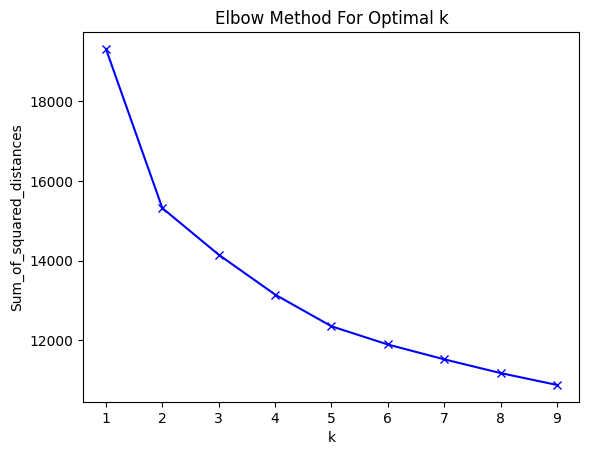

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
# once n of clusters decided...

In [37]:
optimal_k = 12

km = KMeans(n_clusters=optimal_k)
km = km.fit(eigenvectors_all)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


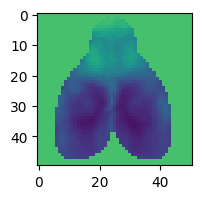

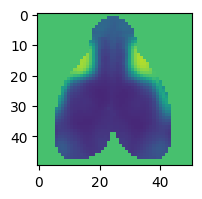

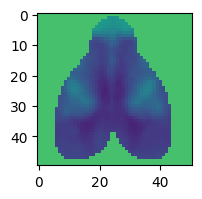

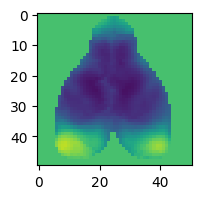

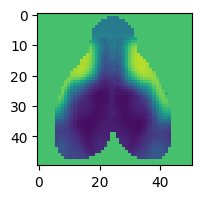

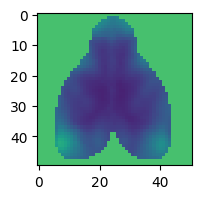

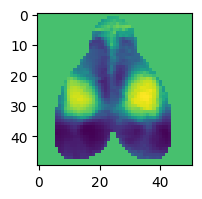

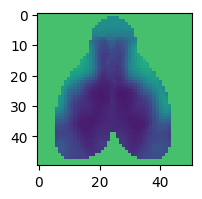

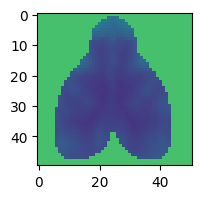

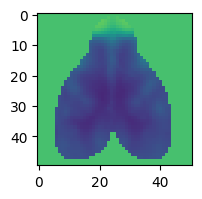

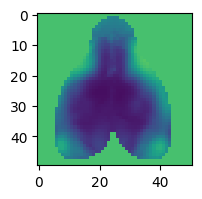

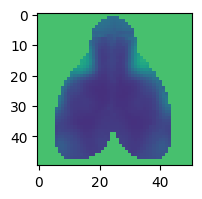

In [38]:
for i,centroid in enumerate(km.cluster_centers_):
    fig = plot_centrality(centroid,H,W,good_indices,km.cluster_centers_.min(),km.cluster_centers_.max())
    fig.set_size_inches(2,2)
    #fig.savefig(str(i)+"centroid")
